## Sometimes the frame count does not match the number of sync pulses
<br>We observe two errors: too many frames OR too few frames.
<br>
<br>If there are too many frames, we can compare the native timestamps (from the .h5 file) to the sync timestamps to find where in the recording the mismatch happens (it is usually in the middle of the recording). Then we can correct the mismatch by removing the extra frames then aligning with the sync clock. Use the below code to do so.
<br>
<br>If there are missing frames, the number of native timestamps is actually equal to the number of sync timestamps. So the video itself is missing frames even though it has timestamps for them. I don't yet know how to correctly align in this case. For now we can delete the first few sync timestamps to match the lengths. So far in our recordings, this type of mismatch only occurs for a small number of frames (< 16 so far).

In [1]:
import h5py
import os
import sys

import cv2
import gspread
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from allensdk.brain_observatory.sync_dataset import Dataset

In [2]:
sys.path.append(r'C:\Users\lesliec\code')

In [3]:
from tbd_eeg.tbd_eeg.data_analysis.eegutils import EEGexp
from tbd_eeg.tbd_eeg.data_analysis.Utilities.behavior_movies import Movie, get_sync_frame_times

In [4]:
%matplotlib notebook

Get Templeton log for experiment list

In [5]:
_gc = gspread.service_account() # need a key file to access the account
_sh = _gc.open('Templeton-log_exp') # open the spreadsheet
_df = pd.DataFrame(_sh.sheet1.get()) # load the first worksheet
metadata = _df.T.set_index(0).T # put it in a nicely formatted dataframe

# Look for experiments that have frame/sync mismatch

In [6]:
psydir = r'P:\\' # this is the directory that contains all of the mouse folders

### Testing with one subject

iloc[21]: 669117 (pilot_ur) has 114 extra frames
<br>iloc[25]: 676726 (aw_psi) frames = sync (NO weird clock shifts)
<br>iloc[34]: 698242 (aw_psi) has 26 extra frames (clock shift in middle of recording)

In [7]:
testrow = metadata.iloc[71]
print(testrow.mouse_name)

recdir = os.path.join(psydir, testrow.mouse_name, testrow.exp_name, r'experiment1\recording1')
print(recdir)

exp = EEGexp(recdir, preprocess=False, make_stim_csv=False)
sync_data = exp._load_sync_dataset()

mouse720762
P:\\mouse720762\aw_ket_2024-02-22_10-43-35\experiment1\recording1
Experiment type: electrical and sensory stimulation


In [8]:
pupilmovie = Movie(filepath=exp.pupilmovie_file, sync_filepath=exp.sync_file, sync_channel='eyetracking')
print('Pupil frame count = {:d}'.format(pupilmovie.frame_count))
print('Pupil sync timestamps = {:d}'.format(len(pupilmovie.sync_timestamps)))

Pupil frame count = 217305
Pupil sync timestamps = 217284


C:\Users\lesliec\code\tbd_eeg\tbd_eeg\data_analysis\Utilities\behavior_movies.py:41: UserWarning: NONMATCHING timestamp counts
There are 217284 timestamps in sync and 217305 timestamps in the associated camera file
these should match
  len(self.sync_timestamps), len(self.timestamps_from_file)))


In [9]:
pupilvid = cv2.VideoCapture(exp.pupilmovie_file)
print('Pupil frame count = {:d}'.format(int(pupilvid.get(cv2.CAP_PROP_FRAME_COUNT))))
pupilsync = sync_data.get_edges(keys=('eyetracking',), kind='rising', units='seconds')
print('Pupil sync count = {:d}'.format(len(pupilsync)))
print('Extra frames = {:d}'.format(int(pupilvid.get(cv2.CAP_PROP_FRAME_COUNT)) - len(pupilsync)))

Pupil frame count = 217305
Pupil sync count = 217284
Extra frames = 21


In [10]:
bodyvid = cv2.VideoCapture(exp.bodymovie_file)
print('Body frame count = {:d}'.format(int(bodyvid.get(cv2.CAP_PROP_FRAME_COUNT))))
bodysync = sync_data.get_edges(keys=('behavior',), kind='rising', units='seconds')
print('Body sync count = {:d}'.format(len(bodysync)))
print('Extra frames = {:d}'.format(int(bodyvid.get(cv2.CAP_PROP_FRAME_COUNT)) - len(bodysync)))

Body frame count = 431599
Body sync count = 431599
Extra frames = 0


### Investigate sync time intervals and frame time intervals

In [10]:
## Load native frame times ##
pupilh5 = h5py.File(exp.pupilmovie_file.replace('.avi','.h5'), 'r')
pupil_ts = np.hstack((0, np.cumsum(pupilh5['frame_intervals'])))

## Load falling edges, intervals between falling edges match frame intervals better ##
pfalling = sync_data.get_edges(keys=('eyetracking',), kind='falling', units='seconds')

In [11]:
print('Pupil frame count = {:d}'.format(int(pupilvid.get(cv2.CAP_PROP_FRAME_COUNT))))
print('Pupil timestamp count = {:d}'.format(len(pupil_ts)))
print('Pupil sync falling edges = {:d}'.format(len(pfalling)))

Pupil frame count = 217305
Pupil timestamp count = 217305
Pupil sync falling edges = 217284


### Some intervals are longer than expected. Do they align?

In [14]:
tt = 0.055
print(np.nonzero(np.diff(pupil_ts) > tt)[0])
print(np.nonzero(np.diff(pfalling) > tt)[0])

[  2149  14049  30659  44949  45089  50719  54889  59749  59919  63819
  66129  77909  78349  80069  94089 101549 101559 104359 109159 111449
 117499 123049 124097 124189 124236 129229 132419 137299 138089 138219
 138249 143729 145689 146219 150019 151899 161509 180649 192299 193729
 197769 203049 213209]
[  2149  14049  30659  44949  45089  50719  54889  59749  59919  63819
  66129  77909  78349  80069  94089 101549 101559 104359 109159 111449
 117499 123049 124097 124189 124236 129229 132419 137299 138068 138198
 138228 143708 145668 146198 149998 151878 161488 180628 192278 193708
 197748 203028 213188]


698242 (aw_psi) = [163165, 163205]
<br> 669117 (pilot_ur) = [139239, 144605]
<br> 689329 (aw_psi) = [61009, 61280]

In [15]:
indwins = [137299, 138089]

<IPython.core.display.Javascript object>


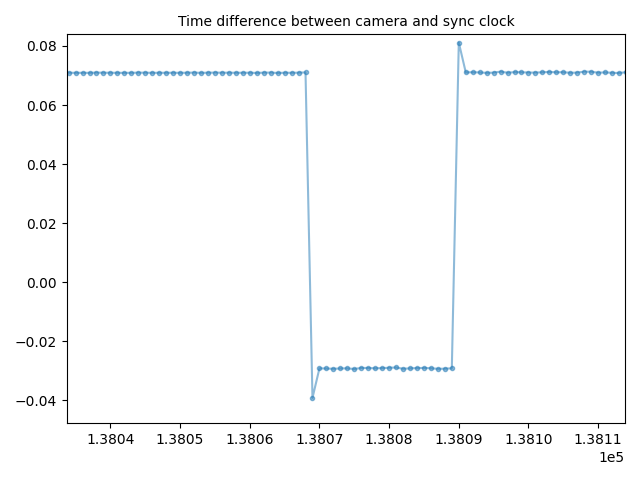

(0.0, 217284.0)

In [16]:
fig, ax = plt.subplots(tight_layout=True)
timediff = (pupil_ts[:len(pfalling)] - pupil_ts[0]) - (pfalling - pfalling[0])
ax.plot(timediff, marker='.', alpha=0.5)
ax.set_title('Time difference between camera and sync clock')
# ax.axvline(indwins[0], color='r', alpha=0.5)
# ax.axvline(indwins[1], color='r', alpha=0.5)
ax.set_xlim(0, len(pfalling))

### Remove extra frame times

In [17]:
len(pupil_ts)

217305

In [18]:
len(pupilsync)

217284

In [19]:
messind = 138068 # 698242-163199, 669117-143986, 689239-61152

if len(pupil_ts) > len(pupilsync):
    num_frames = len(pupil_ts) - len(pupilsync)
    print('There are {:d} extra frames...deleting them.'.format(num_frames))
    new_ts = np.delete(pupil_ts, np.arange(messind, messind+num_frames))
elif len(pupil_ts) < len(pupilsync):
    num_syncs = len(pupilsync) - len(pupil_ts)
    print('There are {:d} extra sync pulses...deleting the extras from the end.'.format(num_syncs))
    new_sync = pupilsync[:len(pupil_ts)]

There are 21 extra frames...deleting them.


#### Test it

<IPython.core.display.Javascript object>


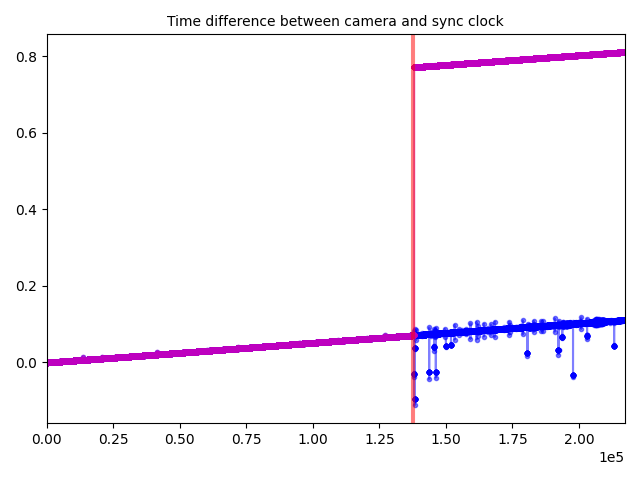

(0.0, 217284.0)

In [20]:
fig, ax = plt.subplots(tight_layout=True)
timediff = (pupil_ts[:len(pfalling)] - pupil_ts[0]) - (pfalling - pfalling[0])
newtimediff = (new_ts - new_ts[0]) - (pfalling - pfalling[0])
ax.plot(timediff, marker='.', color='b', alpha=0.5)
ax.plot(newtimediff, marker='.', color='m', alpha=0.5)
ax.set_title('Time difference between camera and sync clock')
ax.axvline(indwins[0], color='r', alpha=0.5)
ax.axvline(indwins[1], color='r', alpha=0.5)
ax.set_xlim(0, len(pfalling))

## Looks good, now remove frames from pupil .csv

In [21]:
print('Pupil frame count = {:d}'.format(int(pupilvid.get(cv2.CAP_PROP_FRAME_COUNT))))
print('Pupil sync count = {:d}'.format(len(pupilsync)))

Pupil frame count = 217305
Pupil sync count = 217284


In [23]:
files = os.listdir(exp.data_folder)
pupil_file = exp.data_folder + '/' + next(file for file in files if file.split('_')[0] == 'Pupileye')
print(pupil_file)

P:\\mouse720762\aw_ket_2024-02-22_10-43-35\experiment1\recording1/Pupileye_aw_ket_2024-02-22_10-43-35.csv


In [24]:
pupil_data = pd.read_csv(pupil_file)
print(len(pupil_data))
pupil_data.head()

217305


,Time_Frames,X_Position,Y_Position,Radius_1,Radius_2,Angle,Largest_Radius,Eye_Diameter,sync_time
0,0.0,234.750265,231.552384,47.716414,45.514735,1.434510,47.716414,333.743375,NaN
1,1.0,234.450743,231.645710,47.776995,45.763373,1.486652,47.776995,333.009551,NaN
2,2.0,234.437443,231.631225,47.512785,45.930075,1.436727,47.512785,333.198429,NaN
3,3.0,234.510787,231.528114,47.670527,46.187319,1.516922,47.670527,333.594676,NaN
4,4.0,234.651296,231.688082,47.840005,46.607323,1.493985,47.840005,333.349131,NaN


In [25]:
corrected_pupil_data = pupil_data.drop(labels=np.arange(messind, messind+num_frames), axis=0)
print(len(corrected_pupil_data))

217284


In [26]:
corrected_pupil_data['sync_time'] = pupilsync
corrected_pupil_data.head()

,Time_Frames,X_Position,Y_Position,Radius_1,Radius_2,Angle,Largest_Radius,Eye_Diameter,sync_time
0,0.0,234.750265,231.552384,47.716414,45.514735,1.434510,47.716414,333.743375,13.93912
1,1.0,234.450743,231.645710,47.776995,45.763373,1.486652,47.776995,333.009551,13.95229
2,2.0,234.437443,231.631225,47.512785,45.930075,1.436727,47.512785,333.198429,13.97562
3,3.0,234.510787,231.528114,47.670527,46.187319,1.516922,47.670527,333.594676,14.00933
4,4.0,234.651296,231.688082,47.840005,46.607323,1.493985,47.840005,333.349131,14.04255


In [27]:
pupil_data.tail()

,Time_Frames,X_Position,Y_Position,Radius_1,Radius_2,Angle,Largest_Radius,Eye_Diameter,sync_time
217300,217300.0,246.611166,244.140272,100.501483,82.007444,3.100564,100.501483,313.775814,NaN
217301,217301.0,246.292560,244.556377,100.695608,82.450273,3.112027,100.695608,314.103456,NaN
217302,217302.0,246.074691,244.359503,101.002863,82.035933,3.090179,101.002863,314.401588,NaN
217303,217303.0,245.478628,244.039997,100.826734,82.302871,3.089780,100.826734,313.941508,NaN
217304,217304.0,246.389160,244.244733,100.152000,80.745574,3.137430,100.152000,312.600596,NaN


In [28]:
corrected_pupil_data.tail()

,Time_Frames,X_Position,Y_Position,Radius_1,Radius_2,Angle,Largest_Radius,Eye_Diameter,sync_time
217300,217300.0,246.611166,244.140272,100.501483,82.007444,3.100564,100.501483,313.775814,7259.99120
217301,217301.0,246.292560,244.556377,100.695608,82.450273,3.112027,100.695608,314.103456,7260.02038
217302,217302.0,246.074691,244.359503,101.002863,82.035933,3.090179,101.002863,314.401588,7260.05390
217303,217303.0,245.478628,244.039997,100.826734,82.302871,3.089780,100.826734,313.941508,7260.08711
217304,217304.0,246.389160,244.244733,100.152000,80.745574,3.137430,100.152000,312.600596,7260.12166


## Now save pupil .csv with aligned timestamps

In [29]:
corrected_pupil_data.to_csv(pupil_file, index=False)

## Test detrending the line

Doesn't quite work as well as I hoped

In [25]:
slope = np.mean(np.diff(timediff[:indwins[0]]))
detrend_timediff = timediff - slope*np.arange(len(timediff))

In [26]:
fig, ax = plt.subplots(tight_layout=True)
timediff = (pupil_ts[:len(pfalling)] - pupil_ts[0]) - (pfalling - pfalling[0])
ax.plot(timediff, marker='.', color='b', alpha=0.5)
ax.plot(detrend_timediff, marker='.', color='c', alpha=0.5)
ax.set_title('Time difference between camera and sync clock')
ax.axvline(indwins[0], color='r', alpha=0.5)
ax.axvline(indwins[1], color='r', alpha=0.5)
ax.set_xlim(0, len(pfalling))

<IPython.core.display.Javascript object>

(0.0, 174750.0)

In [27]:
avgdt = np.mean(detrend_timediff[:indwins[0]])
print(avgdt)
stddt = np.std(detrend_timediff[:indwins[0]])
print(stddt)

0.0002873595475388248
0.00016291322289725186


<IPython.core.display.Javascript object>


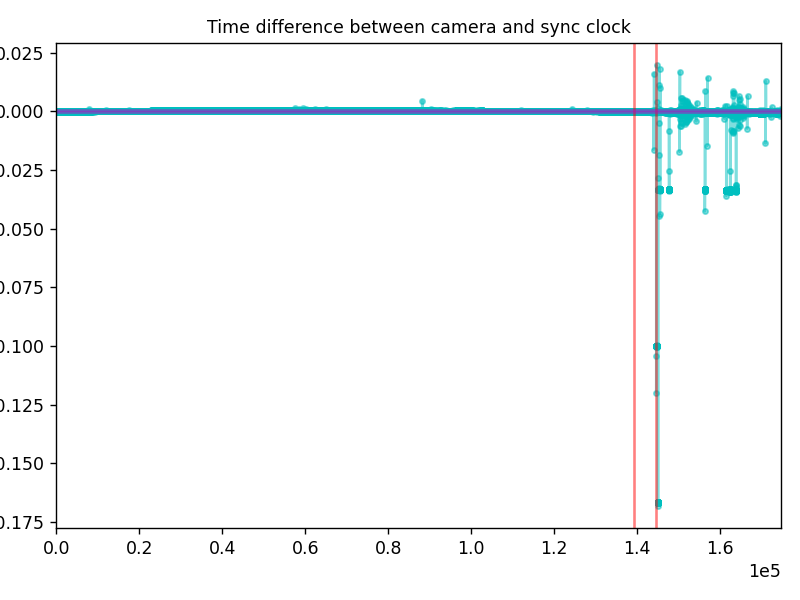

(0.0, 174750.0)

In [29]:
fig, ax = plt.subplots(tight_layout=True)
timediff = (pupil_ts[:len(pfalling)] - pupil_ts[0]) - (pfalling - pfalling[0])
# ax.plot(timediff, marker='.', color='b', alpha=0.5)
ax.plot(detrend_timediff, marker='.', color='c', alpha=0.5)
ax.set_title('Time difference between camera and sync clock')
ax.axvline(indwins[0], color='r', alpha=0.5)
ax.axvline(indwins[1], color='r', alpha=0.5)
ax.axhline(avgdt + 2*stddt, color='m', alpha=0.5)
ax.axhline(avgdt - 2*stddt, color='m', alpha=0.5)
ax.set_xlim(0, len(pfalling))